# Day 08. Exercise 02
# Multiclass classification. One-hot encoding. Random forest

## 0. Imports

In [443]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer

## 1. Preprocessing

1. Read the file [`checker-submits.csv`](https://drive.google.com/file/d/14voc4fNJZiLEFaZyd8nEG-lQt5JjatYw/view?usp=sharing).
2. Create a dataframe `df` with the columns: `uid`, `labname`, `numTrials`, `hour`, `dayofweek` where `hour` is extracted from the `timestamp` as well as the `dayofweek` (`0` is Monday, `6` is Sunday). We will try to predict the day of the week having data about which user made a commit for which lab at which hour and which try it was.
3. Using `OneHotEncoder()` transform your categorical features, delete from the dataframe the initial columns.
4. Use `StandardScaler()` and scale your continuous features.
5. Save the dataframe as `dayofweek.csv`.
6. Before trying out different algorithms, find out the accuracy of the naive algorithms – the one that predicts everything as the most popular class.

In [444]:
# Загружаем данные
df = pd.read_csv('../data/checker_submits.csv')
print("Исходные данные:")
print(df.head())
print(f"Размер данных: {df.shape}")

Исходные данные:
      uid   labname  numTrials                   timestamp
0  user_4  project1          1  2020-04-17 05:19:02.744528
1  user_4  project1          2  2020-04-17 05:22:45.549397
2  user_4  project1          3  2020-04-17 05:34:24.422370
3  user_4  project1          4  2020-04-17 05:43:27.773992
4  user_4  project1          5  2020-04-17 05:46:32.275104
Размер данных: (1686, 4)


In [445]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.day_of_week
# df['dayofweek'].min()

print(f"Размер данных: {df.shape}")
df
df.max()
df.describe()

# df.max(numeric_only=True) - df.min(numeric_only=True)


Размер данных: (1686, 6)


,numTrials,timestamp,hour,dayofweek
count,1686.000000,1686,1686.000000,1686.000000
mean,25.720641,2020-05-07 02:23:36.397669632,15.957295,3.361210
min,1.000000,2020-04-17 05:19:02.744528,0.000000,0.000000
25%,4.000000,2020-05-02 09:44:33.389479936,13.000000,2.000000
50%,13.000000,2020-05-09 22:41:09.708265472,16.000000,3.000000
75%,36.000000,2020-05-13 21:17:20.682178304,20.000000,5.000000
max,164.000000,2020-05-21 20:37:00.290491,23.000000,6.000000
std,31.354122,NaN,4.277533,1.985261


In [446]:
final_df = df[['uid', 'labname', 'numTrials', 'hour', 'dayofweek']].copy()
print("Данные после извлечения признаков:")
print(final_df.head(10))

Данные после извлечения признаков:
      uid   labname  numTrials  hour  dayofweek
0  user_4  project1          1     5          4
1  user_4  project1          2     5          4
2  user_4  project1          3     5          4
3  user_4  project1          4     5          4
4  user_4  project1          5     5          4
5  user_4  project1          6     5          4
6  user_4  project1          7     5          4
7  user_4    laba04          1    11          4
8  user_4    laba04          2    11          4
9  user_4    laba04          3    11          4


In [447]:
# Проверяем распределение целевой переменной
print("Распределение дней недели:")
dayofweek_counts = final_df['dayofweek'].value_counts().sort_index()
days_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
for day, count in dayofweek_counts.items():
    print(f"{days_names[day]} ({day}): {count}")

Распределение дней недели:
Пн (0): 136
Вт (1): 274
Ср (2): 149
Чт (3): 396
Пт (4): 104
Сб (5): 271
Вс (6): 356


In [448]:
# Подготавливаем данные для обучения
X = final_df.drop('dayofweek', axis=1)
y = final_df['dayofweek']
X

,uid,labname,numTrials,hour
0,user_4,project1,1,5
1,user_4,project1,2,5
2,user_4,project1,3,5
3,user_4,project1,4,5
4,user_4,project1,5,5
...,...,...,...,...
1681,user_19,laba06s,9,20
1682,user_1,laba06s,6,20
1683,user_1,laba06s,7,20
1684,user_1,laba06s,8,20


In [449]:
# Определяем категориальные и числовые признаки
numerical_features = ['numTrials', 'hour']
categorical_features = ['uid', 'labname']

In [ ]:
# Создаем трансформер для обработки данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False), categorical_features)
    ]
)
X_processed = preprocessor.fit_transform(X)

In [452]:
# Получаем названия признаков после трансформации
feature_names = (numerical_features + 
                list(preprocessor.named_transformers_['cat'].get_feature_names_out()))
feature_names

['numTrials',
 'hour',
 'uid_user_0',
 'uid_user_1',
 'uid_user_10',
 'uid_user_11',
 'uid_user_12',
 'uid_user_13',
 'uid_user_14',
 'uid_user_15',
 'uid_user_16',
 'uid_user_17',
 'uid_user_18',
 'uid_user_19',
 'uid_user_2',
 'uid_user_20',
 'uid_user_21',
 'uid_user_22',
 'uid_user_23',
 'uid_user_24',
 'uid_user_25',
 'uid_user_26',
 'uid_user_27',
 'uid_user_28',
 'uid_user_29',
 'uid_user_3',
 'uid_user_30',
 'uid_user_31',
 'uid_user_4',
 'uid_user_6',
 'uid_user_7',
 'uid_user_8',
 'labname_code_rvw',
 'labname_lab02',
 'labname_lab03',
 'labname_lab03s',
 'labname_lab05s',
 'labname_laba04',
 'labname_laba04s',
 'labname_laba05',
 'labname_laba06',
 'labname_laba06s',
 'labname_project1']

In [ ]:
print(f"Размер после обработки: {X_processed.shape}")

Размер после обработки: (1686, 43)


In [ ]:
# Создаем датафрейм для сохранения
processed_df = pd.DataFrame(X_processed, columns=feature_names)
processed_df['dayofweek'] = y.values
print(f"Размер: {processed_df.shape}")

Размер: (1686, 44)


## Размер csv-df: (1686, 44)

In [455]:
# Сохраняем обработанные данные
processed_df.to_csv('data/dayofweek.csv', index=False)

In [456]:
# Baseline accuracy (самый популярный класс)
most_common_class = y.value_counts().idxmax()
baseline_accuracy = y.value_counts().max() / len(y)
print(f"Baseline accuracy (самый популярный класс \"{days_names[most_common_class]}\"):\n{baseline_accuracy}")

Baseline accuracy (самый популярный класс "Чт"):
0.23487544483985764


## 2. Algorithms

### a. Logreg

1. Train logistic regression, for the baseline model use `random_state=21`, `fit_intercept=False`. 
2. Calculate the accuracy.
3. Write a function that draws the plot (`barh`) taking coefficients of any trained models, names of the features and the number of `top-n` most important features to display.
4. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model.
5. Remember that it is a multiclass classification and `coef_` returns a matrix, to calculate importance for a feature you need to sum all the individual feature importances for all the target values.

In [ ]:
def plot_feature_importance(importances, feature_names, top_n=10, title="Feature Importance"):
    """Рисует горизонтальную барную диаграмму важности признаков"""
    

    # Получаем топ-N признаков по важности
    indices = np.argsort(np.abs(importances))[-top_n:]
    plt.figure(figsize=(10, 6))

    plt.barh(range(len(indices)), np.abs(importances[indices]))
        # Горизонтальные столбцы: позиции от 0 до len(indices)-1
        # Длина столбцов: значения важности для выбранных индексов

    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        # Подписи по Y: названия признаков для выбранных индексов

    plt.xlabel('Важность признака')
    plt.title(title)
    # plt.tight_layout()
    plt.show()

## LOGISTIC REGRESSION

In [ ]:
# Обучаем логистическую регрессию
logreg = LogisticRegression(random_state=21, fit_intercept=False, solver='liblinear')
logreg.fit(X_processed, y);

logreg_pred = logreg.predict(X_processed)
logreg_accuracy = accuracy_score(y, logreg_pred)
print(f"Logistic Regression accuracy: {logreg_accuracy}")

Logistic Regression accuracy: 0.6215895610913404


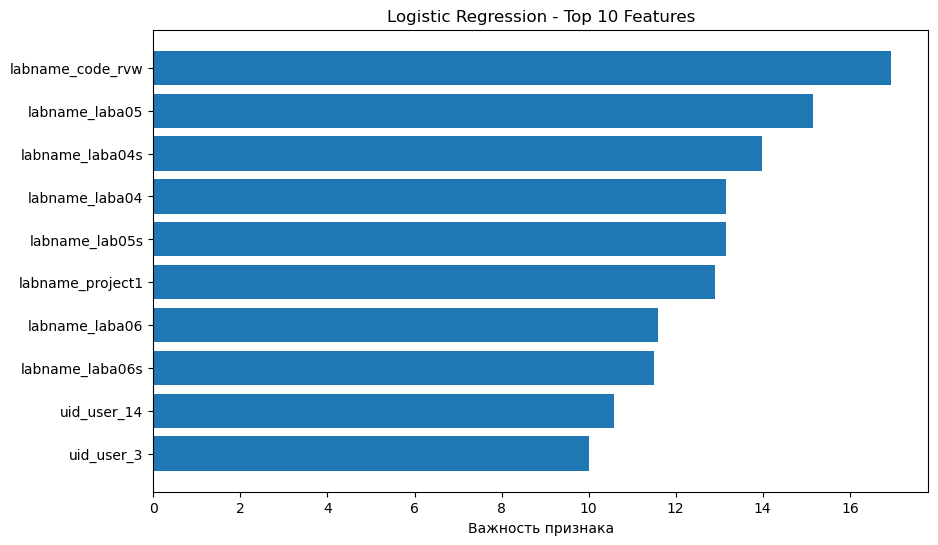

In [459]:
# Важность признаков для многоклассовой классификации

# Суммируем абсолютные значения коэффициентов по всем классам
logreg_importance = np.sum(np.abs(logreg.coef_), axis=0)
# logreg_importance = np.sum((logreg.coef_), axis=0)

    # В многоклассовой классификации один признак может:

    # Сильно влиять на понедельник (+0.8)
    # Слабо влиять на вторник (-0.1)
    # Средне влиять на среду (+0.3)

    # Общая важность признака = сумма его влияния на ВСЕ классы.

plot_feature_importance(logreg_importance, feature_names, title="Logistic Regression - Top 10 Features")

## SVC

### b. SVC

1. Train a `SVC` model, for the baseline model use parameters `kernel='linear'`, `probability=True`, `random_state=21`. 
2. Try different kernels, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model for the linear kernel *

*By default SVC uses “one vs one” strategy of the classification, thus in `coef_` it returns a matrix. To calculate importance for a feature you need to use [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) over the SVC and sum all the individual feature importances for all the target values.

In [460]:
# Пробуем разные ядра
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
svc_results = {}

for kernel in kernels:
    svc = SVC(kernel=kernel, probability=True, random_state=21)
    svc.fit(X_processed, y)
    svc_pred = svc.predict(X_processed)
    svc_acc = accuracy_score(y, svc_pred)
    svc_results[kernel] = svc_acc
    print(f"SVC {kernel}: {svc_acc:.4f}")

SVC linear: 0.7028
SVC poly: 0.8594
SVC rbf: 0.8559
SVC sigmoid: 0.3998


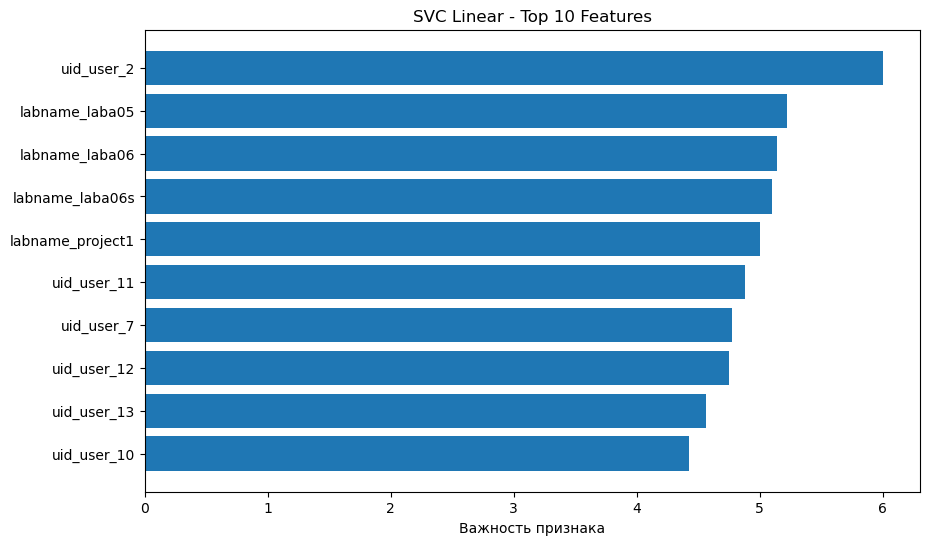

In [461]:
# Используем линейное ядро для анализа важности признаков
svc_ovr = OneVsRestClassifier(SVC(kernel='linear', random_state=21))
svc_ovr.fit(X_processed, y)

# Важность признаков для SVC с линейным ядром
svc_importance = np.sum(np.abs([estimator.coef_[0] for estimator in svc_ovr.estimators_]), axis=0)
plot_feature_importance(svc_importance, feature_names, title="SVC Linear - Top 10 Features")

## Decision tree

### c. Decision tree

1. Train a `DecisionTreeClassifier` using for the baseline model `max_depth=4`, `random_state=21`. 
2. Try different values of `max_depth`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [462]:
# Пробуем разные глубины
depths = [3, 4, 5, 6, 7, 8, 10]
tree_results = {}

for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=21)
    tree.fit(X_processed, y)
    tree_pred = tree.predict(X_processed)
    tree_acc = accuracy_score(y, tree_pred)
    tree_results[depth] = tree_acc
    print(f"Decision Tree depth={depth}: {tree_acc:.4f}")

Decision Tree depth=3: 0.4899
Decision Tree depth=4: 0.5516
Decision Tree depth=5: 0.6109
Decision Tree depth=6: 0.6637
Decision Tree depth=7: 0.7064
Decision Tree depth=8: 0.7503
Decision Tree depth=10: 0.8197


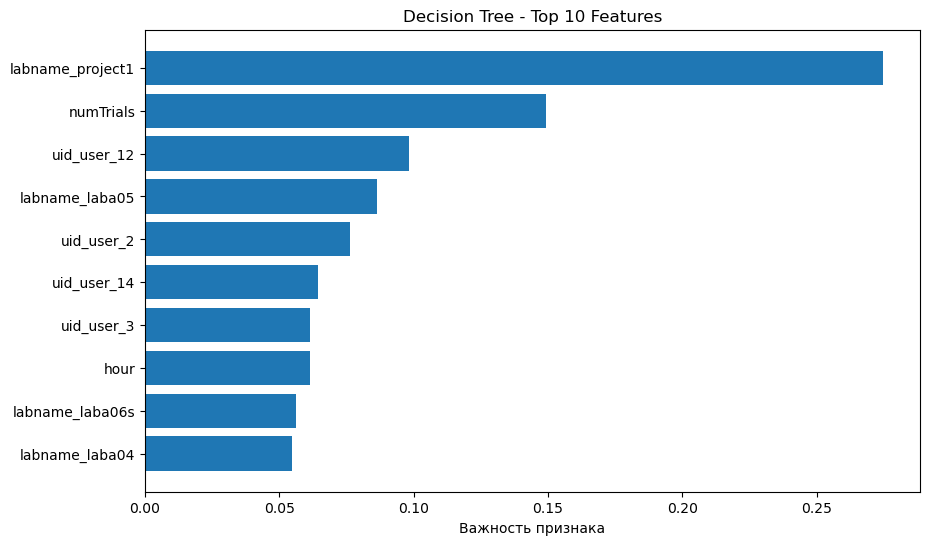

In [463]:
# Базовая модель с глубиной 4
tree_base = DecisionTreeClassifier(max_depth=4, random_state=21)
tree_base.fit(X_processed, y)

# Важность признаков у деревьев есть встроенная
tree_importance = tree_base.feature_importances_
plot_feature_importance(tree_importance, feature_names, title="Decision Tree - Top 10 Features")


## Random forest

### d. Random forest

In real life forest is a set of trees. The same thing is with machine learning. Random forest is a set of individual decision trees (check the documentation for more details).

1. Train a `RandomForestClassifier` using for the baseline model parameters `n_estimators=100`, `max_depth = 25`, `random_state=21`. 
2. Try different values of `max_depth` and `n_estimators`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [464]:
# Базовая модель
rf_base = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=21)
rf_base.fit(X_processed, y)
rf_pred = rf_base.predict(X_processed)
rf_accuracy = accuracy_score(y, rf_pred)
print(f"Random Forest baseline: {rf_accuracy:.4f}")

Random Forest baseline: 1.0000


In [465]:
# Пробуем разные параметры
n_estimators_list = [50, 100, 200]
max_depths = [15, 20, 25, 30]

print("Подбор параметров Random Forest:")
best_params = {}
best_score = 0

for n_est in n_estimators_list:
    for depth in max_depths:
        rf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, random_state=21)
        rf.fit(X_processed, y)
        rf_pred = rf.predict(X_processed)
        rf_acc = accuracy_score(y, rf_pred)
        print(f"n_estimators={n_est}, max_depth={depth}: {rf_acc:.4f}")
        
        if rf_acc > best_score:
            best_score = rf_acc
            best_params = {'n_estimators': n_est, 'max_depth': depth}

print(f"\nЛучшие параметры: {best_params} с accuracy: {best_score:.4f}")

Подбор параметров Random Forest:
n_estimators=50, max_depth=15: 0.9786
n_estimators=50, max_depth=20: 0.9970
n_estimators=50, max_depth=25: 1.0000
n_estimators=50, max_depth=30: 1.0000
n_estimators=100, max_depth=15: 0.9781
n_estimators=100, max_depth=20: 0.9964
n_estimators=100, max_depth=25: 1.0000
n_estimators=100, max_depth=30: 1.0000
n_estimators=200, max_depth=15: 0.9792
n_estimators=200, max_depth=20: 0.9964
n_estimators=200, max_depth=25: 1.0000
n_estimators=200, max_depth=30: 1.0000

Лучшие параметры: {'n_estimators': 50, 'max_depth': 25} с accuracy: 1.0000


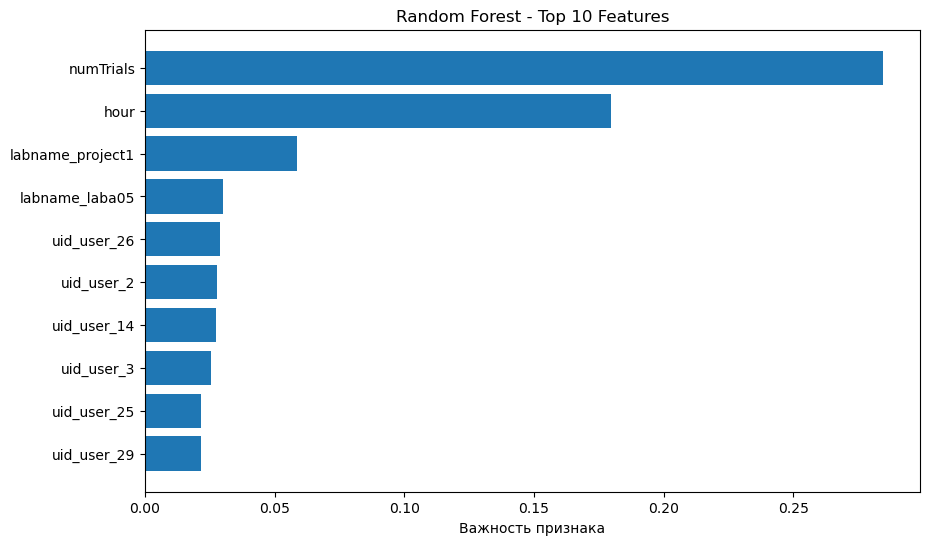

In [466]:
# Важность признаков у Random Forest есть встроенная
rf_importance = rf_base.feature_importances_
plot_feature_importance(rf_importance, feature_names, title="Random Forest - Top 10 Features")

```
Ключевые параметры:
🌳 n_estimators - количество деревьев

Больше деревьев = обычно лучше качество, но медленнее
Стандарт: 100-200 для начала
Принцип: "Один дурак может ошибиться, сто дураков дают мудрый ответ"

📏 max_depth - глубина каждого дерева

Мелкие деревья (1-3) = недообучение
Глубокие деревья (None) = переобучение
Золотая середина: 10-25

🎲 max_features - признаки для разбиения

'sqrt' = √(кол-во признаков) ← стандарт для классификации
Меньше признаков = больше разнообразия между деревьями
Все признаки = деревья становятся похожими
```